In [1]:
import os
import torch
import datasets.paths as d_path
from torch import nn

from engine.cl import train_one_epoch, evaluate
from utils.init import reproducibility, clean_memory_get_device
from config import PhysioNetClinicalDatasetArgs, MCLModelArgs, MultimodalContrastiveLearningArgs, ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets, check_best, end_train, check_best, end_train
from torchvision.models import resnet18, ResNet18_Weights
from models.clinical_ffn import ClinicalFFN
from models.mcl import MultimodalContrastiveLearning
from datasets.physio.clinical import PhysioNetClinicalDataset
from utils.plot import plot_losses
from IPython.display import clear_output

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
reproducibility()
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large 

In [3]:
configs = [
    ConfigArgs(
        training=MultimodalContrastiveLearningArgs(
            name="MCL",
            early_stopping_patience=None,
        ),
        dataset=PhysioNetClinicalDatasetArgs(),
        model=MCLModelArgs(
            name="resnet18"
        )
    ),
    ConfigArgs(
        training=MultimodalContrastiveLearningArgs(
            name="MCL",
            early_stopping_patience=None,
        ),
        dataset=PhysioNetClinicalDatasetArgs(),
        model=MCLModelArgs(
            name="resnet18"
        )
    ),
]

In [4]:
num_epochs = 100  # 200
train_infos: list[TrainingInfo] = []

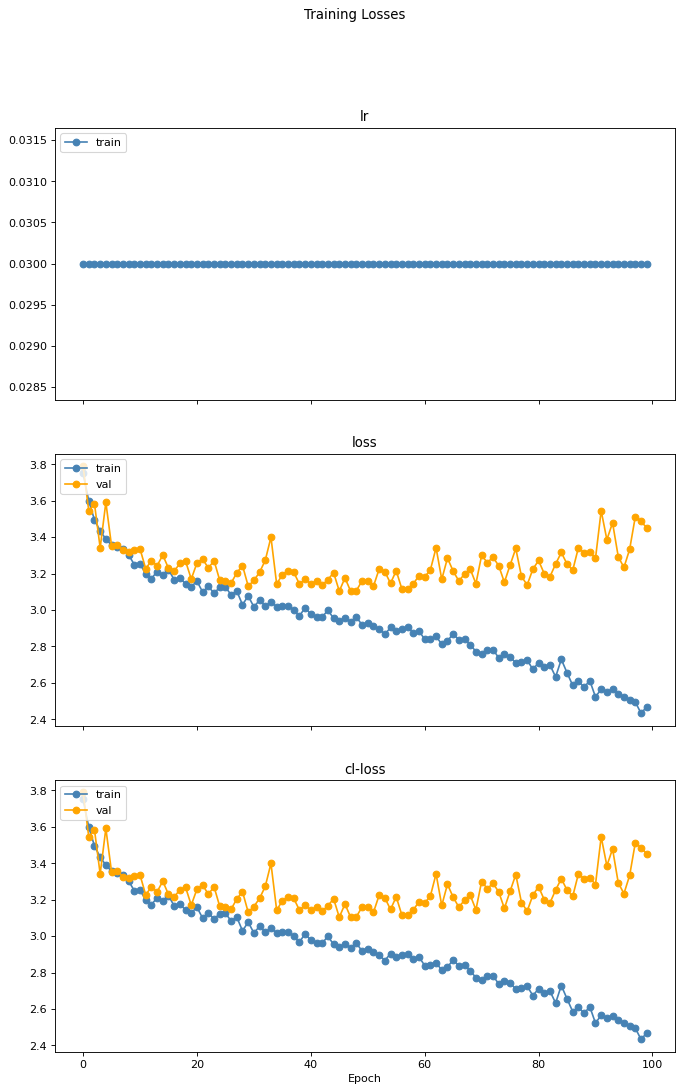

| Epoch [100] Done | It has took [6098.34] min, Avg time: [3659.00] sec/epoch | Estimate time for [100] epochs: [6098.34] min | Epoch took [3197.080036] sec | 
| Training Done, start testing! | [100] Epochs Training time: [365900.108089] seconds, Avg time / Epoch: [3659.0010808899997] seconds
========================================For Training [MCL]========================================
MultimodalContrastiveLearningArgs(name='MCL', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, cl_pj_dim=128, clinical_cat_emb_dim=16, early_stopping_patience=None, warmup_epoch=0)
PhysioNetClinicalDatasetArgs(image_size=128, clinical_num=['age', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity'], clinical_cat=['gender'], categorical_col_maps={'gender': 2}, normalise_clinical_num=True, use_aug=True)
MCLModelArgs(name='resnet50', clinical_emb_dims=16, clinical_out_channels=1000, cl_m1_pool=None, cl_m2_pool=None, cl_lambda_0=0.5, cl_temperature=0.1, cl_pj

In [5]:
for config in configs:
    device = clean_memory_get_device()
    reproducibility()

    train_info = TrainingInfo(config)
    xray_backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    xray_backbone.fc = nn.Linear(
        xray_backbone.fc.in_features, config.model.clinical_out_channels
    )
    clinical_backnone = ClinicalFFN(
        numerical_cols=config.dataset.clinical_num,
        categorical_col_maps=config.dataset.categorical_col_maps,
        embedding_dim=config.model.clinical_emb_dims,
        out_channels=config.model.clinical_out_channels,
    )

    model = MultimodalContrastiveLearning(
        clinical_backbone=clinical_backnone,
        xray_backbone=xray_backbone,
        lambda_0=config.model.cl_lambda_0,
        m1_pool=config.model.cl_m1_pool,
        m2_pool=config.model.cl_m2_pool,
        pj_dim=config.model.cl_pj_dim,
        pj_embedding_dim=config.model.cl_pj_embedding_dim,
        pj_pooled_dim=config.model.cl_pj_pooled_dim,
        temperature=config.model.cl_temperature,
    )
    model.to(device)

    dataset_args = {
        "df_path": os.path.join("spreadsheets", "physio_clinical.csv"),
        "physionet_path": d_path.PHYSIONET_PATH,
        "clinical_numerical_cols": config.dataset.clinical_num,
        "clinical_categorical_cols": config.dataset.clinical_cat,
        "image_size": config.dataset.image_size,
        "normalise_clinical_num": config.dataset.normalise_clinical_num,
        "use_aug": config.dataset.use_aug,
    }

    train_dataset, val_dataset, _ = get_datasets(
        dataset_args=dataset_args,
        dataset_class=PhysioNetClinicalDataset,
    )

    train_dataloader, val_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    optimiser = torch.optim.SGD(
        params=[p for p in model.parameters() if p.requires_grad],
        lr=config.training.learning_rate,
        momentum=config.training.sgd_momentum,
        weight_decay=config.training.weight_decay,
    )

    early_stopper = None
    if config.training.early_stopping_patience:
        early_stopper = EarlyStopper(patience=config.training.early_stopping_patience)

    train_info.timer.start_training()

    for e in range(1, num_epochs + 1):
        train_info.epoch = e
        train_info.timer.start_epoch()
        for t_i in train_infos:
            print(t_i)
        print(train_info)

        train_logger = train_one_epoch(
            model=model,
            optimiser=optimiser,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
        )

        train_info.train_losses.append(train_logger.get_data())

        model.eval()

        val_logger, val_evaluator = evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            return_evaluator=True,
        )

        train_info.val_losses.append(val_logger.get_data())

        clear_output()
        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
        )
        epoch_end_print(train_info, early_stopper, num_epochs)

        if train_info.epoch > config.training.warmup_epoch:
            train_info = check_best(
                train_info=train_info,
                model=model,
                optimiser=optimiser,
                val_evaluator=val_evaluator,
            )
            if early_stopper:
                to_stop = early_stopper.early_stop(train_info.val_losses[-1]["loss"])
                if to_stop:
                    print(
                        f"| Patience reached [{early_stopper.counter}], EarlyStopping end |"
                    )
                    break

    train_info = end_train(
        train_info=train_info,
        model=model,
        optimiser=optimiser,
        val_evaluator=val_evaluator,
    )

    train_infos.append(train_info)

========================================For Training [MCL]========================================
MultimodalContrastiveLearningArgs(name='MCL', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, cl_pj_dim=128, clinical_cat_emb_dim=16, early_stopping_patience=None, warmup_epoch=0)
PhysioNetClinicalDatasetArgs(image_size=128, clinical_num=['age', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity'], clinical_cat=['gender'], categorical_col_maps={'gender': 2}, normalise_clinical_num=True, use_aug=True)
MCLModelArgs(name='resnet50', clinical_emb_dims=16, clinical_out_channels=1000, cl_m1_pool=None, cl_m2_pool=None, cl_lambda_0=0.5, cl_temperature=0.1, cl_pj_pooled_dim=1000, cl_pj_embedding_dim=1000, cl_pj_dim=128)

Best model has been saved to: [MCL_resnet50_accuracy_0_1433_epoch48_10-08-2023 15-58-25]
The final model has been saved to: [MCL_resnet50_accuracy_0_1152_epoch100_10-10-2023 20-07-44]



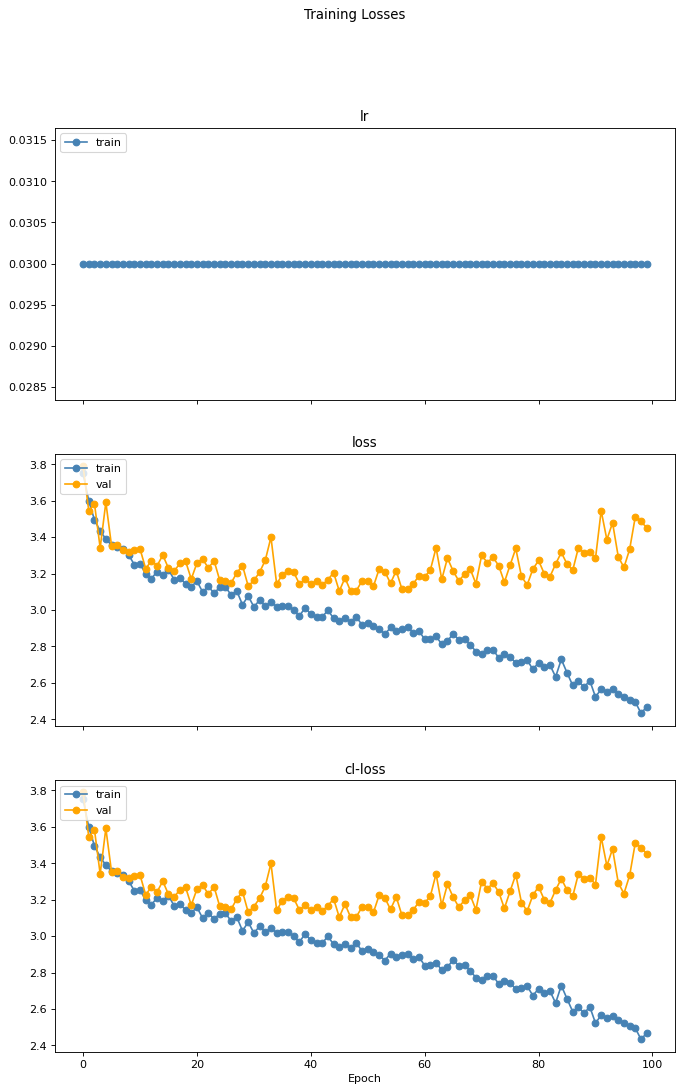

In [7]:
for t in train_infos:
    print(t)
    plot_losses(
        t.train_losses,
        t.val_losses,
    )

In [8]:
# Evaluate all train_infos on the best

from utils.checkpoint import load_checkpoints

for t in train_infos:

    train_info, cp = load_checkpoints(t.best_val_loss_model_path, device)
    config = train_info.config
    xray_backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    clinical_backnone = ClinicalFFN(
        numerical_cols=config.dataset.clinical_num,
        categorical_col_maps=config.dataset.categorical_col_maps,
        embedding_dim=config.model.clinical_emb_dims,
        out_channels=config.model.clinical_out_channels,
    )
    model = MultimodalContrastiveLearning(
        clinical_backbone=clinical_backnone,
        xray_backbone=xray_backbone,
        lambda_0=config.model.cl_lambda_0,
        m1_pool=config.model.cl_m1_pool,
        m2_pool=config.model.cl_m2_pool,
        pj_dim=config.model.cl_pj_dim,
        pj_embedding_dim=config.model.cl_pj_embedding_dim,
        pj_pooled_dim=config.model.cl_pj_pooled_dim,
        temperature=config.model.cl_temperature,
    )
    model.to(device)
    model.load_state_dict(cp["model"])
    model.eval()

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "physio_clinical.csv"),
        "physionet_path": d_path.PHYSIONET_PATH,
        "clinical_numerical_cols": config.dataset.clinical_num,
        "clinical_categorical_cols": config.dataset.clinical_cat,
        "image_size": config.dataset.image_size,
        "normalise_clinical_num": config.dataset.normalise_clinical_num,
        "use_aug": config.dataset.use_aug
    }

    train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_args=dataset_args,
        dataset_class=PhysioNetClinicalDataset,
    )

    _, _, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    _, test_evaluator = evaluate(
            model=model,
            data_loader=test_dataloader,
            device=device,
            return_evaluator=True,
        )
    
    print(t)
    print(test_evaluator.get_performance())
    
    with open(os.path.join('checkpoints',t.best_val_loss_model_path, 'performance.txt'), 'w') as f:
        f.write(str(t) +"\n"+ "Best: \n" +str(test_evaluator.get_performance()))




Test:  [ 0/28]  eta: 0:04:06  model_time: 0.0877 (0.0877)  evaluator_time: 0.0000 (0.0000)  loss: 2.8706 (2.8706)  cl-loss: 2.8706 (2.8706)  time: 8.8170  data: 8.6831  max mem: 1068
Test:  [27/28]  eta: 0:00:08  model_time: 0.0877 (0.0858)  evaluator_time: 0.0000 (0.0000)  loss: 3.0799 (2.9944)  cl-loss: 3.0799 (2.9944)  time: 8.2141  data: 8.1033  max mem: 1068
Test: Total time: 0:03:53 (8.3495 s / it)
Averaged stats: model_time: 0.0877 (0.0858)  evaluator_time: 0.0000 (0.0000)  loss: 3.0799 (2.9944)  cl-loss: 3.0799 (2.9944)
========================================For Training [MCL]========================================
MultimodalContrastiveLearningArgs(name='MCL', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, cl_pj_dim=128, clinical_cat_emb_dim=16, early_stopping_patience=None, warmup_epoch=0)
PhysioNetClinicalDatasetArgs(image_size=128, clinical_num=['age', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity'], clinical_cat=['gende